In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'Y31VT2DNMCWGS2E0SRQCDW4FF54NKWL2HUIYNW1FNGNWOSDV' # your Foursquare ID
CLIENT_SECRET = 'BFDDHVNELE2JCD2QXFJLXS20Y2K0BK14U4OT1D5LXPQLGVZR' # your Foursquare Secret
VERSION = '20210524' # Foursquare API version

# Capstone Project - Battle of the Neighborhoods
# By Laura Pretorius

## Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2018, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

This final project explores the best locations for Mexican restaurants throughout the city of New York. As New York is the most diverse city in the world (800 languages are spoken in New York), it has a long tradition of different ethnical restaurants. People ove hot food! That's why Potentially the owner of the new  restaurant can have great success and consistent profit. However, as with any business, opening a new restaurant requires serious considerations and is more complicated than it seems from the first glance. In particular, the location of the restaurant is one of the most important factors that will affect whether it will have success or a failure. So our project will attempt to answer the questions “Where should the investor open a Mexican Restaurant?” and “Where should I go If I want great Mexican food"

## Data
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

## Methodology
• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Mexican restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphing from Python libraries.

Problem Statement
What is / are the best location(s) for Mexicane cuisine in New York City?
In what Neighborhood and/or borough should the investor open a Mexican restaurant to have the best chance of being successful?
Where would I go in New York City to have the best Mexican food?

### Before we get the data and start exploring it, as seen above we imported all libraries needed
#### NY data we are going to need (Now let's use the codes to get our initial NYC data below)

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

#### lets view the first 5 the rows of the NY data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

### Now we know that there is a total of 306 different Neighborhoods in New York.

# Initial Data Analysis
#### Now let's analyze our initial data.

In [6]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt

%matplotlib inline

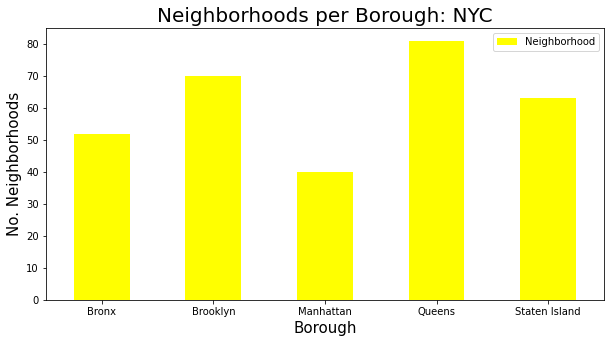

In [7]:
clr = "yellow"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

#### Let's analyze further and see how many Mexican restaurants there are in each neighborhood and borough. After it, graph the results

In [8]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
mexican_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_restaurants=venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(ny_data),')','Mexican Restaurants in '+Neighborhood+', '+Borough+':'+str(len(mexican_restaurants)))
    print(row)
    for resturant_detail in mexican_restaurants.values.tolist():
        id, name , category=resturant_detail
        mexican_rest_ny = mexican_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Mexican Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Mexican Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Mexican Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Mexican Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Mexican Restaurants in Kingsbridge, Bronx:3
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Mexican Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Mexican Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Mexican Restaurants in Norwood, Bronx:1
['

In [9]:

#mexican_rest_ny.to_csv('mexican_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
mexican_rest_ny.to_csv('mexican_rest_ny_tocsv1.csv')

In [10]:
mexican_ny = pd.read_csv('mexican_rest_ny_tocsv1.csv')
mexican_rest_ny.tail()

,Borough,Neighborhood,ID,Name
124,Brooklyn,Fulton Ferry,4f69f2b76d86f87117bb13ab,Gran Eléctrica
125,Brooklyn,Dumbo,4f69f2b76d86f87117bb13ab,Gran Eléctrica
126,Brooklyn,Homecrest,507e08fae4b0998ce3421276,El Mexicano Restaurante & Cafe Inc
127,Brooklyn,Homecrest,4a3ada26f964a5205fa01fe3,La Villita Mexican Restaurant
128,Bronx,Kingsbridge Heights,4b403740f964a520e8b625e3,Montezuma Mexican Restaurant


In [11]:
mexican_ny.shape

(129, 5)

#### We got 129 Mexican Restaurants across the New York City.

#### As we continue our analysis, we see below that although Manhattan had the least number of neighborhoods, it does have the highest number of Mexican restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Bushwick, East Village,Financial district,Noho,Prospect hights have the highest number of Mexican restaurants in all of NYC and is actually located in the boroughs of Manhattan and Brooklyn.

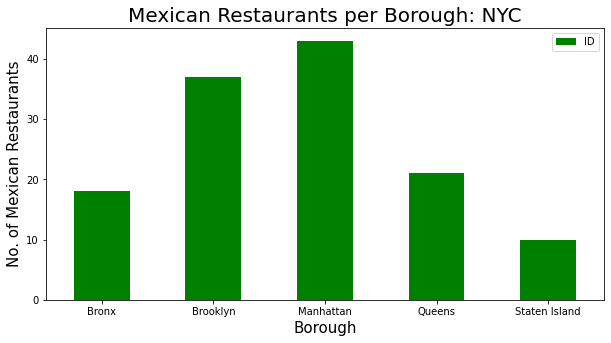

In [12]:

mexican_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='green')
plt.title('Mexican Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Mexican Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

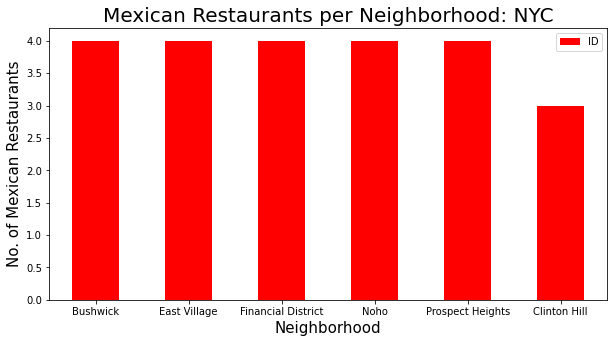

In [13]:
NOofNeigh = 6 # top number for graphing all the same past 6
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color='red')
plt.title('Mexican Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Mexican Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [14]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='Noho']

,Borough,Neighborhood,ID,Name
110,Manhattan,Noho,518ae551498e2f46f121c613,El Diablito Taqueria
111,Manhattan,Noho,553ac3c8498e6d2422de7741,Rosie's
112,Manhattan,Noho,4bb270a8a32876b0d39900fe,Downtown Bakery
113,Manhattan,Noho,536da20a498e8a08809d145a,Essex Taqueria


#### So the there are 4 Mexican restaurants in in eacj of the following areas : Bushwick, East Village,Financial district,Noho,Prospect hights.
I will be choosing Noho, as according to other research , this is the safest area in Manhattan

### Now we will get the ranking of each restaurant for further analysis.

In [15]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in mexican_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(mexican_rest_ny),')','processed')
    mexican_rest_stats_ny = mexican_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
mexican_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60aca748eb93c628a7ef2487'}, 'response': {'venue': {'id': '5217dd2811d2d06ccafb77d3', 'name': 'Estrellita Poblana V', 'contact': {'phone': '7188843825', 'formattedPhone': '(718) 884-3825'}, 'location': {'address': '240 W 231st St', 'lat': 40.879687039717524, 'lng': -73.906256832975, 'labeledLatLngs': [{'label': 'display', 'lat': 40.879687039717524, 'lng': -73.906256832975}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['240 W 231st St', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/estrellita-poblana-v/5217dd2811d2d06ccafb77d3', 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'http://www.estrel

KeyError: 'venue'

In [16]:
mexican_rest_stats_ny.to_csv('mexican_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [17]:
mexican_rest_stats_ny.shape

(50, 7)


We got statistics for all 50 Mexican Restaurants in New York city.

Let's check what values we have in our DataFrame

In [18]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.6+ KB


We see that the values like Likes, Tips are string values. We would need to convert them into float for further analysis

In [19]:
mexican_rest_stats_ny['Likes'] = mexican_rest_stats_ny['Likes'].astype('float64')
mexican_rest_stats_ny['Tips'] = mexican_rest_stats_ny['Tips'].astype('float64')
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.0+ KB


## Now when the data types look correct, let's continue our analysis.

In [20]:
mexican_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,43.420000,7.028000,18.260000
std,54.557249,2.209538,19.952812
min,0.000000,0.000000,0.000000
25%,6.500000,6.925000,3.000000
50%,24.000000,7.500000,8.000000
75%,54.000000,8.125000,35.250000
max,257.000000,9.100000,73.000000


In [21]:
# Resturant with maximum Likes
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              5ae8ed8eb3c961002b3360da
Name                             Oxomoco
Likes                                257
Rating                                 9
Tips                                  54
Name: 18, dtype: object

In [22]:
# Resturant with maximum Ratings
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                133
Rating                               9.1
Tips                                  73
Name: 7, dtype: object

In [23]:
# Resturant with maximum Tips
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                133
Rating                               9.1
Tips                                  73
Name: 7, dtype: object

#### Now let's identify and visualize neighborhood with the maximum average rating of restaurants

In [24]:
ny_neighborhood_stats=mexican_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
23,Parkchester,9.100000
5,Chinatown,8.650000
19,North Side,8.600000
13,Greenpoint,8.433333
28,South Side,8.200000
4,Bushwick,8.075000
31,Westchester Square,8.000000
25,Prospect Heights,7.925000
15,Kingsbridge,7.833333
14,Kensington,7.800000


Above are the top neighborhoods with the highest average ratings of Mexican restaurants.

In [25]:
ny_borough_stats=mexican_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.166667
1,Brooklyn,7.150000
0,Bronx,6.540000


Similarly these are the average ratings of mexican Restaurants for each Borough

## visualize the results

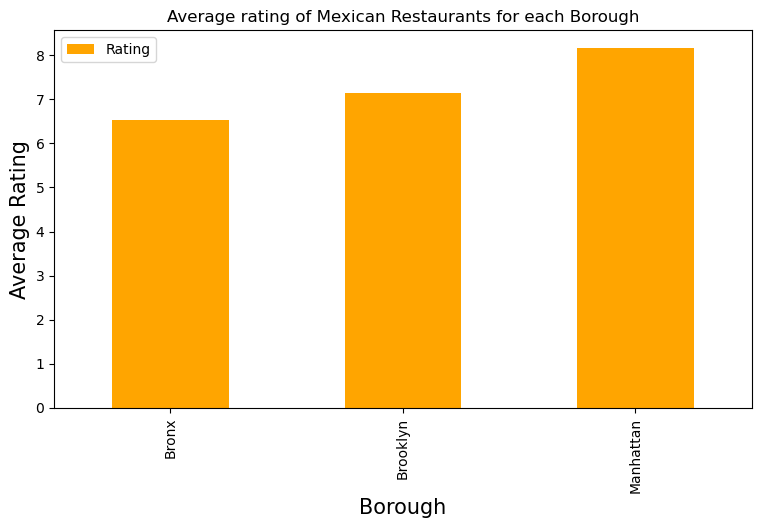

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Mexican Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
mexican_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color='orange')
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [27]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
4,Bushwick,8.075000
5,Chinatown,8.650000
13,Greenpoint,8.433333
19,North Side,8.600000
23,Parkchester,9.100000
28,South Side,8.200000
31,Westchester Square,8.000000


We will join this Dataset to original New York data to get longitude and latitude

In [28]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bushwick,40.698116,-73.925258,8.075000
1,Manhattan,Chinatown,40.715618,-73.994279,8.650000
2,Brooklyn,Greenpoint,40.730201,-73.954241,8.433333
3,Brooklyn,North Side,40.714823,-73.958809,8.600000
4,Bronx,Parkchester,40.837938,-73.856003,9.100000
5,Brooklyn,South Side,40.710861,-73.958001,8.200000
6,Bronx,Westchester Square,40.840619,-73.842194,8.000000



### Now we will show this data on a map

In [29]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Let's add a new field to dataframe for labeling purpose

In [30]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

### Conclusion

Manhattan and Brooklyn have the best rated Mexican restaurants on average. Staten Island and The Bronx have the least amount of Mexicanrestaurants per borough. However,  Manhattan and Brooklyn has the highest number of Mexican Restaurants in all of NY. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most number of Mexican restaurants. Based on the above information, I would state that Manhattan and Brooklyn are the best locations for Mexican Restaurante in NYC. To have the best shot of success, I would open a Mexican restaurant in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 7.0 on a scale of 1.0 to 10.0 and has less amount of Mexican restaurants than Manhattan, making competition easier. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. Finally, I would go to Parkcheser for the best Mexican restaurante, with the highest rating.
As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.

#### END - Thank you